### Langraph Experiments

In [1]:
from IPython.display import Image, display
import pandas as pd
import json
from dotenv import load_dotenv
import time
import yfinance as yf

from fuzzywuzzy import process

from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Literal, Optional

In [2]:
# Constants
FUZZY_LIMIT = 5
LOW_CONFIDENCE_THRESHOLD = 50  # Minimum score to consider
HIGH_CONFIDENCE_THRESHOLD = 90  # If score ≥ 90, skip LLM

In [3]:
# Load env variables from .env.example
load_dotenv("../.env")

True

In [4]:
# initialize model for large number of input tokens
llmg = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [5]:
# Initialize the LLM
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

In [6]:
# Load CSV of NSE companies
df = pd.read_csv("../data/EQUITY_L.csv")  # Assumes columns: "Company Name", "Symbol"
company_names = df["NAME OF COMPANY"].tolist()

In [7]:
# Define the state
class GraphState(TypedDict):
    query: str
    query_type: str  # Options: "single_stock", "multiple_general_stock", "greeting", "other", "reset"
    symbol: str
    stock_info: dict
    stock_info_timestamp: float  # Timestamp for stock_info freshness
    response: str

In [8]:
# Prompt to detect follow-up queries
prompt_detect_follow_up = ChatPromptTemplate.from_template(
    "Determine if the following query is a follow-up to a previous stock query or a new query. "
    "Follow-up queries refer to a previously mentioned stock (e.g., using 'it', 'that stock', or no company name) or request to reset the session (e.g., 'reset session'). "
    "Respond with one word: 'follow_up', 'new', or 'reset'. "
    "Query: {query}"
)

# Prompt to classify query
prompt_classify = ChatPromptTemplate.from_template(
    "Classify the following query into one of four categories: "
    "'single_stock' (about a specific stock, e.g., 'What is the price of Tata Motors?', 'Should I invest in Bajaj Finance?'), "
    "'multiple_general_stock' (about multiple stocks or general stock market, e.g., 'Compare SBI and HDFC Bank' or 'How is the stock market doing?'), "
    "'greeting' (general greetings like 'hello', 'hi', or 'good morning'), or "
    "'other' (any other query, e.g., 'What's the weather?'). "
    "Respond with only one word: 'single_stock', 'multiple_general_stock', 'greeting', or 'other'. "
    "Query: {query}"
)

# Prompt to extract company name
prompt_extract_symbol = ChatPromptTemplate.from_template(
    "Extract only the company or stock name from the user's stock-related query. "
    "Respond with the company name or stock ticker as a single string. "
    "Query: {query}"
)

# Prompt to disambiguate company name
prompt_disambiguate = ChatPromptTemplate.from_template(
    "A user asked about the company: '{extracted_name}'.\n"
    "Here is a list of possible company names:\n{match_list_str}\n\n"
    "Which one do you think they meant? Reply with the exact company name from the list. "
    "If none are correct, reply with 'NO_MATCH'."
)

# Prompt to answer user query
prompt_answer_query = ChatPromptTemplate.from_template(
    "You are a helpful financial expert who can provide answers to user queries.\n\n"
    "You are provided with structured stock-related data for a company: {stock_info}\n\n"
    "The user has asked: {query}\n\n"
    "Your task:\n"
    "- If the query can be answered using ONLY the provided data, give a clear, concise response (max 150 words).\n"
    "- If the data is insufficient to fully answer the query, state clearly that the available information is not enough.\n\n"
    "Do not use any external knowledge or assumptions. Base your answer strictly on the given data."
)

# Prompt for polite rejection (non-stock queries)
prompt_reject_other = ChatPromptTemplate.from_template(
    "Politely inform the user that this app only handles queries about a single stock. "
    "Do not provide any information related to the query: {query}"
)

# Prompt for polite rejection (multiple/general stock queries)
prompt_reject_multi = ChatPromptTemplate.from_template(
    "Politely inform the user that this app is designed to assist with the analysis of a single stock at a time. "
    "Do not provide any information related to the query: {query}"
)

In [54]:
# # Node to detect follow-up or reset queries
# def detect_follow_up(state: GraphState, config: Optional[RunnableConfig] = None) -> GraphState:
#     chain = prompt_detect_follow_up | llm
#     result = chain.invoke({"query": state["query"]}).content.strip()
    
#     if result == "reset":
#         state["query_type"] = "reset"
#         return state
    
#     if result == "follow_up":
#         # Safely access config and checkpointer
#         if config and isinstance(config, dict) and "configurable" in config:
#             thread_id = config["configurable"].get("thread_id")
#             checkpointer = config["configurable"].get("checkpointer")
#             if thread_id and checkpointer:
#                 checkpoint = checkpointer.get({"configurable": {"thread_id": thread_id}})
#                 if (checkpoint and isinstance(checkpoint, dict) and 
#                     "state" in checkpoint and 
#                     checkpoint["state"].get("symbol") and 
#                     checkpoint["state"].get("stock_info")):
#                     state["symbol"] = checkpoint["state"]["symbol"]
#                     state["stock_info"] = checkpoint["state"]["stock_info"]
#                     state["stock_info_timestamp"] = checkpoint["state"].get("stock_info_timestamp", 0.0)
#                     state["query_type"] = "single_stock"
#                 else:
#                     state["response"] = "No previous stock context found. Please specify a company name."
#                     state["symbol"] = "NO_MATCH"
#                     state["query_type"] = "other"
#             else:
#                 state["response"] = "No previous stock context found. Please specify a company name."
#                 state["symbol"] = "NO_MATCH"
#                 state["query_type"] = "other"
#         else:
#             state["response"] = "No previous stock context found. Please specify a company name."
#             state["symbol"] = "NO_MATCH"
#             state["query_type"] = "other"
#     else:
#         state["query_type"] = None  # Proceed to classify as new query
    
#     return state

In [9]:
# Node to detect follow-up or reset queries
def detect_follow_up(state: GraphState, config: Optional[RunnableConfig] = None) -> GraphState:
    chain = prompt_detect_follow_up | llm
    result = chain.invoke({"query": state["query"]}).content.strip()
    if result == "reset":
        state["query_type"] = "reset"
        return state
    elif result == "follow_up":
        # Load previous state from checkpoint
        checkpointer = config.get("configurable", {}).get("checkpointer")
        thread_id = config.get("configurable", {}).get("thread_id")
        if checkpointer and thread_id:
            checkpoint = checkpointer.get({"configurable": {"thread_id": thread_id}})
            if checkpoint and "state" in checkpoint and checkpoint["state"].get("symbol") and checkpoint["state"].get("stock_info"):
                state["symbol"] = checkpoint["state"]["symbol"]
                state["stock_info"] = checkpoint["state"]["stock_info"]
                state["stock_info_timestamp"] = checkpoint["state"].get("stock_info_timestamp", 0.0)
                state["query_type"] = "single_stock"
            else:
                state["response"] = "No previous stock context found. Please specify a company name."
                state["symbol"] = "NO_MATCH"
                state["stock_info"] = None
                state["query_type"] = "other"
        else:
            state["response"] = "No previous stock context found. Please specify a company name."
            state["symbol"] = "NO_MATCH"
            state["query_type"] = "other"
    else:
        state["query_type"] = None  # Proceed to classify as new query
    return state

In [10]:
# Node to check query type using LLM
def check_query_type(state: GraphState) -> GraphState:
    chain = prompt_classify | llm
    result = chain.invoke({"query": state["query"]}).content.strip()
    state["query_type"] = result
    return state

# Node to answer user query
def answer_user_query(state: GraphState) -> GraphState:
    if state["symbol"] == "NO_MATCH":
        return state  # Response already set
    chain = prompt_answer_query | llm
    formatted_info = json.dumps(state["stock_info"], indent=2)
    result = chain.invoke({"query": state["query"], "stock_info": formatted_info}).content.strip()
    state["response"] = result
    return state

# Node to handle multiple/general stock queries
def handle_multiple_general_stock_query(state: GraphState) -> GraphState:
    chain = prompt_reject_multi | llm
    result = chain.invoke({"query": state["query"]}).content
    state["response"] = result
    return state

# Node to handle greetings
def handle_greeting(state: GraphState) -> GraphState:
    state["response"] = "Hello! I'm here to help with queries about a single stock. Please ask about a specific stock."
    return state

# Node to handle non-stock, non-greeting queries
def handle_other_query(state: GraphState) -> GraphState:
    chain = prompt_reject_other | llm
    result = chain.invoke({"query": state["query"]}).content
    state["response"] = result
    return state

# Node to reset memory
def reset_session(state: GraphState) -> GraphState:
    state["response"] = "Session reset. Please start a new query about a single stock."
    state["symbol"] = ""
    state["stock_info"] = {}
    state["stock_info_timestamp"] = 0.0
    state["query_type"] = "reset"
    return state

In [11]:
# Node to extract company symbol for single stock queries
def extract_symbol(state: GraphState) -> GraphState:
    chain = prompt_extract_symbol | llm
    extracted_name = chain.invoke({"query": state["query"]}).content.strip()
    
    # Fuzzy matching
    matches = process.extract(extracted_name, company_names, limit=FUZZY_LIMIT)
    best_match, best_score = matches[0]
    
    # High-confidence match
    if best_score >= HIGH_CONFIDENCE_THRESHOLD:
        state["symbol"] = df[df["NAME OF COMPANY"] == best_match]["SYMBOL"].values[0]
        return state
    
    # Filter matches
    filtered_matches = [(name, score) for name, score in matches if score >= LOW_CONFIDENCE_THRESHOLD]
    if not filtered_matches:
        state["response"] = "No company matches found for your query. Please specify a valid company name."
        state["symbol"] = "NO_MATCH"
        return state
    
    # Disambiguate with LLM
    match_list_str = "\n".join([f"- {name}" for name, _ in filtered_matches])
    chain = prompt_disambiguate | llm
    llm_response = chain.invoke({"extracted_name": extracted_name, "match_list_str": match_list_str}).content.strip()
    
    if llm_response == "NO_MATCH":
        state["response"] = "No company matches found for your query. Please specify a valid company name."
        state["symbol"] = "NO_MATCH"
    elif llm_response in df["NAME OF COMPANY"].values:
        state["symbol"] = df[df["NAME OF COMPANY"] == llm_response]["SYMBOL"].values[0]
    else:
        state["response"] = "Unable to identify the company. Please clarify the company name."
        state["symbol"] = "NO_MATCH"
    
    return state

In [12]:
# Node to fetch stock data
def get_stock_info(state: GraphState) -> GraphState:
    if state["symbol"] == "NO_MATCH":
        return state  # Response already set in extract_symbol
    try:
        stock_symbol = state["symbol"]
        stock = yf.Ticker(f"{stock_symbol}.NS")
        info = stock.info
        # Read the CSV that contains the keys to keep
        keys_df = pd.read_csv("../important_keys.csv", header=None)
        keys_to_keep = set(keys_df.iloc[0].dropna().tolist())
        # Filter dictionary
        filtered_info = {k: v for k, v in info.items() if k in keys_to_keep}
        state["stock_info"] = filtered_info
    except Exception as e:
        state["response"] = f"Failed to fetch stock data for {stock_symbol}: {str(e)}. Please try again or specify a different company."
        state["stock_info"] = {}
        state["symbol"] = "NO_MATCH"
    return state

In [13]:
# Conditional edge to route based on follow-up detection
def route_follow_up(state: GraphState) -> Literal["check_query_type", "extract_symbol", "reset_session"]:
    if state["query_type"] == "reset":
        return "reset_session"
    elif state["query_type"] == "single_stock":
        return "get_stock_info"  # Follow-up query with symbol already set
    else:
        return "check_query_type"

# Conditional edge to route based on query_type
def route_query(state: GraphState) -> Literal["single_stock", "multiple_general_stock", "greeting", "other"]:
    return state["query_type"]

# Conditional edge to check symbol extraction result
def check_symbol(state: GraphState) -> Literal["get_stock_info", "end"]:
    return "end" if state["symbol"] == "NO_MATCH" else "get_stock_info"

In [17]:
# Build the graph
workflow = StateGraph(GraphState)

In [18]:
# Add nodes
workflow.add_node("detect_follow_up", detect_follow_up)
workflow.add_node("check_query_type", check_query_type)
workflow.add_node("extract_symbol", extract_symbol)
workflow.add_node("get_stock_info", get_stock_info)
workflow.add_node("answer_user_query", answer_user_query)
workflow.add_node("handle_multiple_general_stock_query", handle_multiple_general_stock_query)
workflow.add_node("handle_greeting", handle_greeting)
workflow.add_node("handle_other_query", handle_other_query)
workflow.add_node("reset_session", reset_session)

In [19]:
# Add edges
workflow.set_entry_point("detect_follow_up")
workflow.add_conditional_edges(
    "detect_follow_up",
    route_follow_up,
    {
        "check_query_type": "check_query_type",
        "get_stock_info": "get_stock_info",
        "reset_session": "reset_session"
    }
)
workflow.add_conditional_edges(
    "check_query_type",
    route_query,
    {
        "single_stock": "extract_symbol",
        "multiple_general_stock": "handle_multiple_general_stock_query",
        "greeting": "handle_greeting",
        "other": "handle_other_query"
    }
)
workflow.add_conditional_edges(
    "extract_symbol",
    check_symbol,
    {
        "get_stock_info": "get_stock_info",
        "end": END
    }
)
workflow.add_edge("get_stock_info", "answer_user_query")
workflow.add_edge("answer_user_query", END)
workflow.add_edge("handle_multiple_general_stock_query", END)
workflow.add_edge("handle_greeting", END)
workflow.add_edge("handle_other_query", END)
workflow.add_edge("reset_session", END)

In [20]:
# Configure memory
checkpointer = MemorySaver()

# Compile the graph with checkpointer
app = workflow.compile(checkpointer=checkpointer)

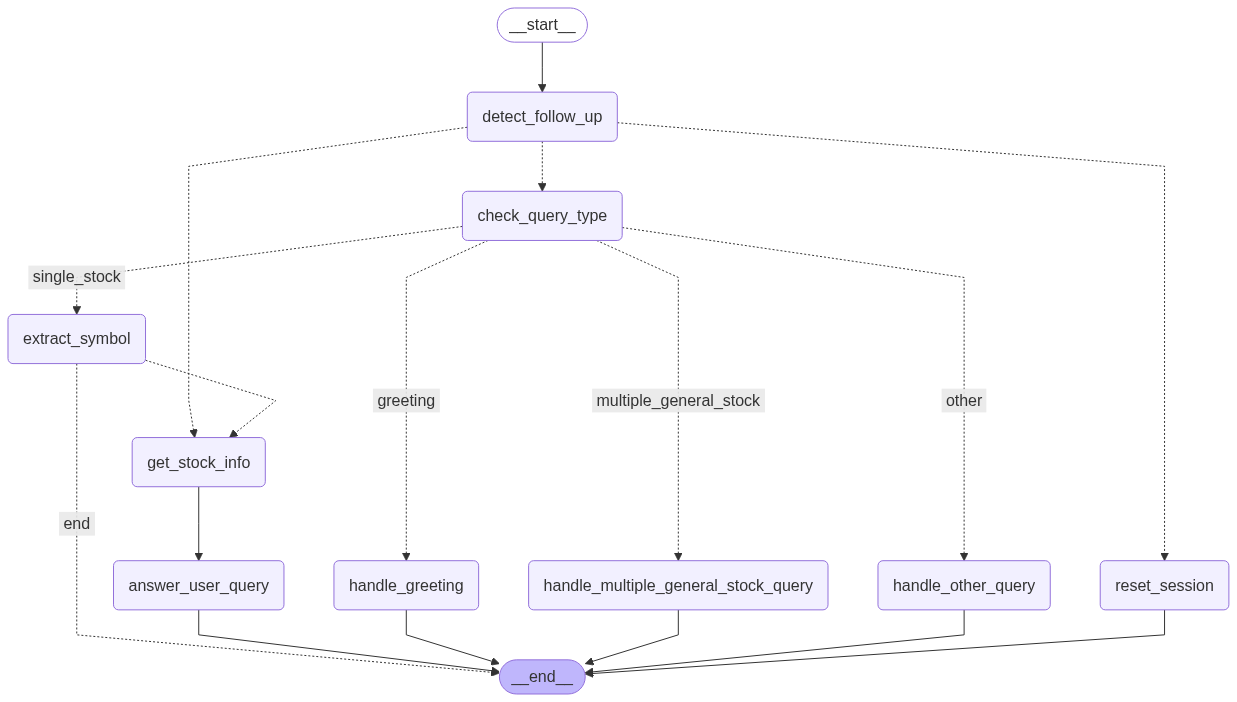

In [50]:
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
"Should I invest in Reliance Industries based on its current valuation metrics?"
"Is Tata Steel a risky investment based on its recent price movements?"
"How attractive is HDFC Bank for dividend-focused investors?"
"Is Reliance Industries currently trading near its yearly high or low?"
"What does the recent trading volume of Tata Steel suggest about investor interest?"
"Is HDFC Bank's market capitalization reasonable for its sector?"
"Does Reliance Industries' P/E ratio indicate it is overvalued or undervalued compared to typical industry standards?"
"How stable is Tata Steel’s stock price based on its historical data?"

In [21]:
thread_id = "user_session_1"  # Unique identifier for user session
config = {"configurable": {"thread_id": thread_id, "checkpointer": checkpointer}}

In [77]:
# output = app.invoke({"query": input()}, config=config)
# print(output['response'])

In [22]:
# Test with a single stock query
result = app.invoke({"query": "What is the price of Havells India?"}, config=config)
print("Single stock response:", result["response"])

Single stock response: The current price of Havells India Limited is approximately ₹1463.5.


In [84]:
# # Test with a follow-up query
# result = app.invoke({"query": "What is its dividend yield?"}, config=config)
# print("Follow-up response:", result["response"])

In [23]:
# The states are returned in reverse chronological order.
states = list(app.get_state_history(config))

for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

()
1f0773bb-de6b-6885-8005-17aee18df417

('answer_user_query',)
1f0773bb-cc70-6ab3-8004-cbbe07b5867f

('get_stock_info',)
1f0773bb-bfe0-6ee6-8003-387e165f3ec7

('extract_symbol',)
1f0773bb-b270-6d8f-8002-1138143917f9

('check_query_type',)
1f0773bb-a840-6db6-8001-282f047e32e4

('detect_follow_up',)
1f0773bb-9d53-6e12-8000-b077592e9a82

('__start__',)
1f0773bb-9d53-6e11-bfff-a239437f986b



In [25]:
# This is the state before last (states are listed in chronological order)
selected_state = states[1]
# print(selected_state.next)
# print(selected_state.values)

In [99]:
checkpoint_values = selected_state.values
checkpoint_values["query"] = 'Is it a good time to buy'

In [28]:
new_config = app.update_state(selected_state.config, values={"query": "what is the dividend yield?"})
print(new_config)

{'configurable': {'thread_id': 'user_session_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0773c4-c958-675e-8005-df93a3c92702'}}


In [32]:
output = app.invoke(None, new_config)
output['response']

'The dividend yield for Havells India Limited is 0.67%.'